In [ ]:
#| default_exp models.xlstm

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

# xLSTM
The `xLSTM` was built to improve the `LSTM` architecture by introducing exponential gating and a modified memory structure. This implementation uses the `xLSTM` block stack to encode a timeseries, and subsequently an `MLP` decoder to create forecasts.

**References**<br>-[Maximilian Beck and Korbinian Pöppel and Markus Spanring and Andreas Auer and Oleksandra Prudnikova and Michael Kopp and Günter Klambauer and Johannes Brandstetter and Sepp Hochreiter. "xLSTM: Extended Long Short-Term Memory" (2024).](https://arxiv.org/abs/2405.04517})<br>

In [ ]:
#| hide
import logging
from fastcore.test import test_eq
from nbdev.showdoc import show_doc
from neuralforecast.common._model_checks import check_model

/home/osprangers/Repositories/neuralforecast/.venv/lib/python3.10/site-packages/nbdev/doclinks.py:17: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources,importlib
/home/osprangers/Repositories/neuralforecast/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-25 09:37:27,834	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-07-25 09:37:27,895	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output

In [ ]:
#| export
from typing import Optional

import torch
import warnings
import torch.nn as nn

from neuralforecast.losses.pytorch import MAE
from neuralforecast.common._base_model import BaseModel
from neuralforecast.common._modules import MLP

try:
    from xlstm.xlstm_block_stack import xLSTMBlockStack, xLSTMBlockStackConfig
    from xlstm.blocks.mlstm.block import mLSTMBlockConfig
    from xlstm.blocks.slstm.block import sLSTMBlockConfig
    IS_XLSTM_INSTALLED = True
except ImportError:
    IS_XLSTM_INSTALLED = False

In [ ]:
importlib.util.find_spec("ninja_")


In [ ]:
#| export
class xLSTM(BaseModel):
    """ xLSTM

    xLSTM encoder, with MLP decoder.

    **Parameters:**<br>
    `h`: int, forecast horizon.<br>
    `input_size`: int, considered autorregresive inputs (lags), y=[1,2,3,4] input_size=2 -> lags=[1,2].<br>
    `encoder_n_blocks`: int=2, number of blocks for the xLSTM.<br>
    `encoder_hidden_size`: int=128, units for the xLSTM's hidden state size.<br>
    `encoder_bias`: bool=True, whether or not to use biases within xLSTM blocks.<br>
    `encoder_dropout`: float=0., dropout regularization applied within xLSTM blocks.<br>
    `decoder_hidden_size`: int=128, size of hidden layer for the MLP decoder.<br>
    `decoder_layers`: int=2, number of layers for the MLP decoder.<br>
    `decoder_dropout`: float=0., dropout regularization applied within the MLP decoder.<br>
    `decoder_activation`: str='GELU', activation function for the MLP decoder, see [activations collection](https://docs.pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity).<br>
    `backbone`: str='sLSTM', backbone for the xLSTM, either 'sLSTM' or 'mLSTM'.<br>
    `futr_exog_list`: str list, future exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `stat_exog_list`: str list, static exogenous columns.<br>
    `exclude_insample_y`: bool=False, whether to exclude the target variable from the input.<br>
    `recurrent`: bool=False, whether to produce forecasts recursively (True) or direct (False).<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `max_steps`: int=1000, maximum number of training steps.<br>
    `learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
    `num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
    `early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
    `val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
    `batch_size`: int=32, number of differentseries in each batch.<br>
    `valid_batch_size`: int=None, number of different series in each validation and test batch.<br>
    `windows_batch_size`: int=128, number of windows to sample in each training batch, default uses all.<br>
    `inference_windows_batch_size`: int=1024, number of windows to sample in each inference batch, -1 uses all.<br>
    `start_padding_enabled`: bool=False, if True, the model will pad the time series with zeros at the beginning, by input size.<br>
    `training_data_availability_threshold`: Union[float, List[float]]=0.0, minimum fraction of valid data points required for training windows. Single float applies to both insample and outsample; list of two floats specifies [insample_fraction, outsample_fraction]. Default 0.0 allows windows with only 1 valid data point (current behavior).<br>
    `step_size`: int=1, step size between each window of temporal data.<br>    
    `scaler_type`: str='robust', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `alias`: str, optional,  Custom name of the model.<br>
    `optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
    `optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
    `lr_scheduler`: Subclass of 'torch.optim.lr_scheduler.LRScheduler', optional, user specified lr_scheduler instead of the default choice (StepLR).<br>
    `lr_scheduler_kwargs`: dict, optional, list of parameters used by the user specified `lr_scheduler`.<br>    
    `dataloader_kwargs`: dict, optional, list of parameters passed into the PyTorch Lightning dataloader by the `TimeSeriesDataLoader`. <br>
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>

    **References:**<br>
    -[Maximilian Beck, Korbinian Pöppel, Markus Spanring, Andreas Auer, Oleksandra Prudnikova, Michael Kopp, Günter Klambauer, Johannes Brandstetter, Sepp Hochreiter (2024). "xLSTM: Extended Long Short-Term Memory"](https://arxiv.org/abs/2405.04517)

    """
    # Class attributes
    EXOGENOUS_FUTR = True
    EXOGENOUS_HIST = True
    EXOGENOUS_STAT = True
    MULTIVARIATE = False    # If the model produces multivariate forecasts (True) or univariate (False)
    RECURRENT = False        # If the model produces forecasts recursively (True) or direct (False)

    def __init__(self,
                 h: int,
                 input_size: int = -1,
                 inference_input_size: Optional[int] = None,
                 h_train: int = 1,
                 encoder_n_blocks: int = 2,
                 encoder_hidden_size: int = 128,
                 encoder_bias: bool = True,
                 encoder_dropout: float = 0.1,
                 decoder_hidden_size: int = 128,
                 decoder_layers: int = 1,
                 decoder_dropout: float = 0.,
                 decoder_activation: str = 'GELU',
                 backbone: str = "sLSTM",
                 futr_exog_list = None,
                 hist_exog_list = None,
                 stat_exog_list = None,
                 exclude_insample_y = False,
                 recurrent = False,
                 loss = MAE(),
                 valid_loss = None,
                 max_steps: int = 1000,
                 learning_rate: float = 1e-3,
                 num_lr_decays: int = -1,
                 early_stop_patience_steps: int =-1,
                 val_check_steps: int = 100,
                 batch_size = 32,
                 valid_batch_size: Optional[int] = None,
                 windows_batch_size = 128,
                 inference_windows_batch_size = 1024,
                 start_padding_enabled = False,
                 training_data_availability_threshold = 0.0,
                 step_size: int = 1,
                 scaler_type: str = 'robust',
                 random_seed = 1,
                 drop_last_loader = False,
                 alias: Optional[str] = None,
                 optimizer = None,
                 optimizer_kwargs = None,
                 lr_scheduler = None,
                 lr_scheduler_kwargs = None,
                 dataloader_kwargs = None,
                 **trainer_kwargs):
        
        if recurrent:
            warnings.warn("xLSTM does not support recurrent forecasts. Setting recurrent=False.")
            recurrent = False

        super(xLSTM, self).__init__(
            h=h,
            input_size=input_size,
            inference_input_size=inference_input_size,
            h_train=h_train,
            futr_exog_list=futr_exog_list,
            hist_exog_list=hist_exog_list,
            stat_exog_list=stat_exog_list,
            exclude_insample_y = exclude_insample_y,
            loss=loss,
            valid_loss=valid_loss,
            max_steps=max_steps,
            learning_rate=learning_rate,
            num_lr_decays=num_lr_decays,
            early_stop_patience_steps=early_stop_patience_steps,
            val_check_steps=val_check_steps,
            batch_size=batch_size,
            valid_batch_size=valid_batch_size,
            windows_batch_size=windows_batch_size,
            inference_windows_batch_size=inference_windows_batch_size,
            start_padding_enabled=start_padding_enabled,
            training_data_availability_threshold=training_data_availability_threshold,
            step_size=step_size,
            scaler_type=scaler_type,
            random_seed=random_seed,
            drop_last_loader=drop_last_loader,
            alias=alias,
            optimizer=optimizer,
            optimizer_kwargs=optimizer_kwargs,
            lr_scheduler=lr_scheduler,
            lr_scheduler_kwargs=lr_scheduler_kwargs,
            dataloader_kwargs=dataloader_kwargs,
            **trainer_kwargs
        )

        if not IS_XLSTM_INSTALLED:
            raise ImportError(
                "Please install `xlstm`. You also need to install `mlstm_kernels` for backend='mLSTM' and `ninja` for backend='sLSTM'."
            )        

        # xLSTM input size (1 for target variable y)
        input_encoder = 1 + self.hist_exog_size + self.stat_exog_size + self.futr_exog_size

        # Architecture
        self.feature_projection = nn.Linear(
            in_features=input_encoder,
            out_features=encoder_hidden_size
        )
        if backbone == "sLSTM":
            block_stack_config = xLSTMBlockStackConfig(slstm_block=sLSTMBlockConfig(), context_length=input_size, num_blocks=encoder_n_blocks, embedding_dim=encoder_hidden_size, bias=encoder_bias, dropout=encoder_dropout)
        elif backbone == "mLSTM":
            block_stack_config = xLSTMBlockStackConfig(mlstm_block=mLSTMBlockConfig(), context_length=input_size, num_blocks=encoder_n_blocks, embedding_dim=encoder_hidden_size, bias=encoder_bias, dropout=encoder_dropout)        
        self.hist_encoder = xLSTMBlockStack(block_stack_config)        

        # Decoder MLP
        self.mlp_decoder = MLP(in_features=encoder_hidden_size + self.futr_exog_size,
                            out_features=self.loss.outputsize_multiplier,
                            hidden_size=decoder_hidden_size,
                            num_layers=decoder_layers,
                            activation=decoder_activation,
                            dropout=decoder_dropout)
        self.temporal_projection = nn.Linear(self.input_size, self.h)            

    def forward(self, windows_batch):
        
        # Parse windows_batch
        encoder_input = windows_batch['insample_y']                         # [B, seq_len, 1]
        futr_exog     = windows_batch['futr_exog']                          # [B, seq_len, F]
        hist_exog     = windows_batch['hist_exog']                          # [B, seq_len, X]
        stat_exog     = windows_batch['stat_exog']                          # [B, S]

        # Concatenate y, historic and static inputs              
        batch_size, seq_len = encoder_input.shape[:2]
        if self.hist_exog_size > 0:
            encoder_input = torch.cat((encoder_input, hist_exog), dim=2)    # [B, seq_len, 1] + [B, seq_len, X] -> [B, seq_len, 1 + X]

        if self.stat_exog_size > 0:
            # print(encoder_input.shape)
            stat_exog = stat_exog.unsqueeze(1).repeat(1, seq_len, 1)        # [B, S] -> [B, seq_len, S]
            encoder_input = torch.cat((encoder_input, stat_exog), dim=2)    # [B, seq_len, 1 + X] + [B, seq_len, S] -> [B, seq_len, 1 + X + S]

        if self.futr_exog_size > 0:
            encoder_input = torch.cat((encoder_input, 
                                       futr_exog[:, :seq_len]), dim=2)      # [B, seq_len, 1 + X + S] + [B, seq_len, F] -> [B, seq_len, 1 + X + S + F]

        encoder_input = self.feature_projection(encoder_input)                    # [B, seq_len, 1 + X + S + F] -> [B, seq_len, rnn_hidden_state]
        hidden_state = self.hist_encoder(encoder_input)                 # [B, seq_len, rnn_hidden_state]
        hidden_state = hidden_state.permute(0, 2, 1)               # [B, seq_len, rnn_hidden_state] -> [B, rnn_hidden_state, seq_len]
        hidden_state = self.temporal_projection(hidden_state)        # [B, rnn_hidden_state, seq_len] -> [B, rnn_hidden_state, h]
        hidden_state = hidden_state.permute(0, 2, 1)               # [B, rnn_hidden_state, h] -> [B, h, rnn_hidden_state]
        
        if self.futr_exog_size > 0:
            futr_exog_futr = futr_exog[:, -self.h:]                    # [B, h, F]
            hidden_state = torch.cat((hidden_state, 
                                        futr_exog_futr), dim=-1)         # [B, h, rnn_hidden_state] + [B, h, F] -> [B, h, rnn_hidden_state + F]

        output = self.mlp_decoder(hidden_state)                        # [B, h, rnn_hidden_state + F] -> [B, h, n_output]

        return output

In [ ]:
show_doc(xLSTM)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/xlstm.py#L26){target="_blank" style="float:right; font-size:smaller"}

### xLSTM

>      xLSTM (h:int, input_size:int=-1, inference_input_size:Optional[int]=None,
>             h_train:int=1, encoder_n_blocks:int=2,
>             encoder_hidden_size:int=128, encoder_bias:bool=True,
>             encoder_dropout:float=0.1, decoder_hidden_size:int=128,
>             decoder_layers:int=1, decoder_dropout:float=0.0,
>             decoder_activation:str='GELU', backbone:str='sLSTM',
>             futr_exog_list=None, hist_exog_list=None, stat_exog_list=None,
>             exclude_insample_y=False, recurrent=False, loss=MAE(),
>             valid_loss=None, max_steps:int=1000, learning_rate:float=0.001,
>             num_lr_decays:int=-1, early_stop_patience_steps:int=-1,
>             val_check_steps:int=100, batch_size=32,
>             valid_batch_size:Optional[int]=None, windows_batch_size=128,
>             inference_windows_batch_size=1024, start_padding_enabled=False,
>             training_data_availability_threshold=0.0, step_size:int=1,
>             scaler_type:str='robust', random_seed=1, drop_last_loader=False,
>             alias:Optional[str]=None, optimizer=None, optimizer_kwargs=None,
>             lr_scheduler=None, lr_scheduler_kwargs=None,
>             dataloader_kwargs=None, **trainer_kwargs)

*xLSTM

xLSTM encoder, with MLP decoder.

**Parameters:**<br>
`h`: int, forecast horizon.<br>
`input_size`: int, considered autorregresive inputs (lags), y=[1,2,3,4] input_size=2 -> lags=[1,2].<br>
`encoder_n_blocks`: int=2, number of blocks for the xLSTM.<br>
`encoder_hidden_size`: int=128, units for the xLSTM's hidden state size.<br>
`encoder_bias`: bool=True, whether or not to use biases within xLSTM blocks.<br>
`encoder_dropout`: float=0., dropout regularization applied within xLSTM blocks.<br>
`decoder_hidden_size`: int=128, size of hidden layer for the MLP decoder.<br>
`decoder_layers`: int=2, number of layers for the MLP decoder.<br>
`decoder_dropout`: float=0., dropout regularization applied within the MLP decoder.<br>
`decoder_activation`: str='GELU', activation function for the MLP decoder, see [activations collection](https://docs.pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity).<br>
`futr_exog_list`: str list, future exogenous columns.<br>
`hist_exog_list`: str list, historic exogenous columns.<br>
`stat_exog_list`: str list, static exogenous columns.<br>
`exclude_insample_y`: bool=False, whether to exclude the target variable from the input.<br>
`recurrent`: bool=False, whether to produce forecasts recursively (True) or direct (False).<br>
`loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`max_steps`: int=1000, maximum number of training steps.<br>
`learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
`num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
`early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
`val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
`batch_size`: int=32, number of differentseries in each batch.<br>
`valid_batch_size`: int=None, number of different series in each validation and test batch.<br>
`windows_batch_size`: int=128, number of windows to sample in each training batch, default uses all.<br>
`inference_windows_batch_size`: int=1024, number of windows to sample in each inference batch, -1 uses all.<br>
`start_padding_enabled`: bool=False, if True, the model will pad the time series with zeros at the beginning, by input size.<br>
`training_data_availability_threshold`: Union[float, List[float]]=0.0, minimum fraction of valid data points required for training windows. Single float applies to both insample and outsample; list of two floats specifies [insample_fraction, outsample_fraction]. Default 0.0 allows windows with only 1 valid data point (current behavior).<br>
`step_size`: int=1, step size between each window of temporal data.<br>    
`scaler_type`: str='robust', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
`random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
`drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
`alias`: str, optional,  Custom name of the model.<br>
`optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
`optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
`lr_scheduler`: Subclass of 'torch.optim.lr_scheduler.LRScheduler', optional, user specified lr_scheduler instead of the default choice (StepLR).<br>
`lr_scheduler_kwargs`: dict, optional, list of parameters used by the user specified `lr_scheduler`.<br>    
`dataloader_kwargs`: dict, optional, list of parameters passed into the PyTorch Lightning dataloader by the `TimeSeriesDataLoader`. <br>
`**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>

**References:**<br>
-[Maximilian Beck, Korbinian Pöppel, Markus Spanring, Andreas Auer, Oleksandra Prudnikova, Michael Kopp, Günter Klambauer, Johannes Brandstetter, Sepp Hochreiter (2024). "xLSTM: Extended Long Short-Term Memory"](https://arxiv.org/abs/2405.04517)*

In [ ]:
show_doc(xLSTM.fit, name='xLSTM.fit')

---

### xLSTM.fit

>      xLSTM.fit (dataset, val_size=0, test_size=0, random_seed=None,
>                 distributed_config=None)

*Fit.

The `fit` method, optimizes the neural network's weights using the
initialization parameters (`learning_rate`, `windows_batch_size`, ...)
and the `loss` function as defined during the initialization.
Within `fit` we use a PyTorch Lightning `Trainer` that
inherits the initialization's `self.trainer_kwargs`, to customize
its inputs, see [PL's trainer arguments](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).

The method is designed to be compatible with SKLearn-like classes
and in particular to be compatible with the StatsForecast library.

By default the `model` is not saving training checkpoints to protect
disk memory, to get them change `enable_checkpointing=True` in `__init__`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`val_size`: int, validation size for temporal cross-validation.<br>
`random_seed`: int=None, random_seed for pytorch initializer and numpy generators, overwrites model.__init__'s.<br>
`test_size`: int, test size for temporal cross-validation.<br>*

In [ ]:
show_doc(xLSTM.predict, name='xLSTM.predict')

---

### xLSTM.predict

>      xLSTM.predict (dataset, test_size=None, step_size=1, random_seed=None,
>                     quantiles=None, **data_module_kwargs)

*Predict.

Neural network prediction with PL's `Trainer` execution of `predict_step`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`test_size`: int=None, test size for temporal cross-validation.<br>
`step_size`: int=1, Step size between each window.<br>
`random_seed`: int=None, random_seed for pytorch initializer and numpy generators, overwrites model.__init__'s.<br>
`quantiles`: list of floats, optional (default=None), target quantiles to predict. <br>
`**data_module_kwargs`: PL's TimeSeriesDataModule args, see [documentation](https://pytorch-lightning.readthedocs.io/en/1.6.1/extensions/datamodules.html#using-a-datamodule).*

In [ ]:
#| hide
# Unit tests for models
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
logging.getLogger("lightning_fabric").setLevel(logging.ERROR)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    check_model(xLSTM, ["airpassengers"])

xLSTM: checking forecast AirPassengers dataset
{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=128', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=4', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas 

INFO:xlstm.blocks.slstm.src.cuda_init:Before compilation and loading of slstm.
Using /home/osprangers/.cache/torch_extensions/py310_cu128 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/osprangers/.cache/torch_extensions/py310_cu128/slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0/build.ninja...
Building extension module slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
INFO:xlstm.blocks.slstm.src.cuda_init:After compilation and loading of slstm.


ninja: no work to do.
{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=128', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=4', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '--extra-device-vec

INFO:xlstm.blocks.slstm.src.cuda_init:Before compilation and loading of slstm.
Using /home/osprangers/.cache/torch_extensions/py310_cu128 as PyTorch extensions root...
No modifications detected for re-loaded extension module slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0, skipping build step...
Loading extension module slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
INFO:xlstm.blocks.slstm.src.cuda_init:After compilation and loading of slstm.


In [ ]:
#| hide
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast.utils import AirPassengersDF as Y_df
from neuralforecast.tsdataset import TimeSeriesDataset

## Usage Example

{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=64', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=4', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '--extra-device-vectorization', '-DSLSTM_H

INFO:xlstm.blocks.slstm.src.cuda_init:Before compilation and loading of slstm.
Using /home/osprangers/.cache/torch_extensions/py310_cu128 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/osprangers/.cache/torch_extensions/py310_cu128/slstm_HS64BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0/build.ninja...
/home/osprangers/Repositories/neuralforecast/.venv/lib/python3.10/site-packages/torch/utils/cpp_extension.py:2356: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module slstm_HS64BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module slstm_HS64BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
INFO:xlstm.blocks.slstm.src.c

ninja: no work to do.
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.69it/s]


[]

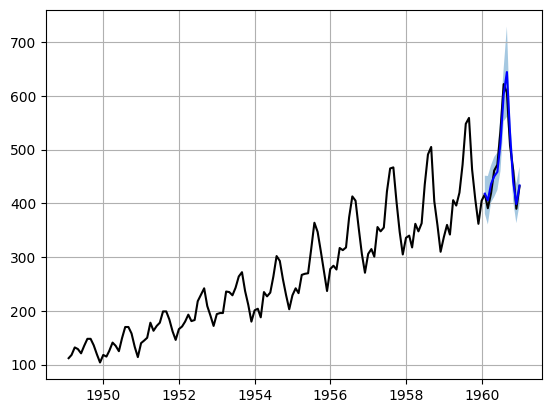

In [ ]:
#| eval: false
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
# from neuralforecast.models import xLSTM
from neuralforecast.losses.pytorch import DistributionLoss
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

nf = NeuralForecast(
    models=[xLSTM(h=12, 
                 input_size=8,
                 loss=DistributionLoss(distribution="Normal", level=[80, 90]),
                 encoder_n_blocks=1,
                 encoder_hidden_size=64,
                 decoder_hidden_size=64,
                 decoder_layers=1,
                 max_steps=400,
                 futr_exog_list=['y_[lag12]'],
                 stat_exog_list=['airline1'],
                 )
    ],
    freq='ME'
)
nf.fit(df=Y_train_df, static_df=AirPassengersStatic)
Y_hat_df = nf.predict(futr_df=Y_test_df)

# Plots
Y_hat_df = Y_hat_df.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['xLSTM-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'][-12:], 
                 y1=plot_df['xLSTM-lo-90'][-12:].values,
                 y2=plot_df['xLSTM-hi-90'][-12:].values,
                 alpha=0.4, label='level 90')
plt.grid()
plt.plot()